In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from scipy import stats

In [10]:
# pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


# Question 1

In [97]:
data1 = pd.read_parquet('data1.parquet', engine='pyarrow')

In [98]:
data1.head(10)

,x,y
0,12.209516,36.021575
1,62.623142,162.746072
2,-14.712353,166.459738
3,130.624579,551.308062
4,121.652246,208.207596
5,53.244766,210.445025
6,169.351484,722.974727
7,134.692400,463.214255
8,-45.130682,4.321998
9,169.558196,760.244366


In [99]:
data1.shape

(103, 2)

<AxesSubplot:xlabel='x', ylabel='y'>

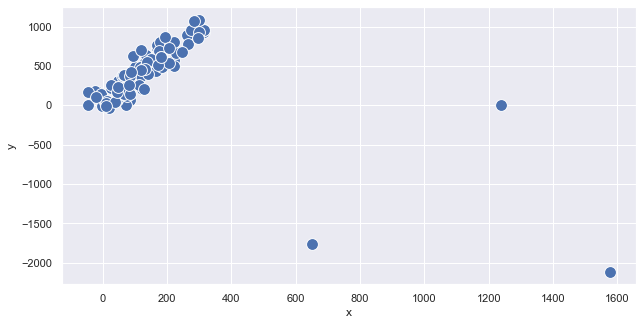

In [100]:
sns.set(rc={'figure.figsize':(10.3,5.1)})
sns.scatterplot(data=data1, x='x', y='y', s=140)

# Question 2

<span style="color:blue;font-weight:680;font-size:20px"> 
Linear Regression assumptions:
</span>
<ul>
    <li>Linear relationship.</li>
    <li>Normality of the residuals.</li>
    <li>No or little multicollinearity.</li>
    <li>Homoscedasticity.</li>
</ul>



We will check all these assumptions first, in order to understand if using a simple Linear regression in this case is a good idea.

In [101]:
data2 = pd.read_parquet('data2.parquet', engine='pyarrow')

In [102]:
data2.head(10)

,x,y
0,0.000000,10.248357
1,0.101010,9.974390
2,0.202020,10.490277
3,0.303030,11.143792
4,0.404040,10.037640
5,0.505051,10.076331
6,0.606061,11.571186
7,0.707071,11.008568
8,0.808081,9.979617
9,0.909091,10.972444


In [103]:
data2.shape

(100, 2)

At a first look, seems like there is a midle-strong linear relationship beetween predctor and response variable.

However, the correlation matrix below tells us that there is only 0.46 of Pearson correlation coefficient between the variables.

<AxesSubplot:xlabel='x', ylabel='y'>

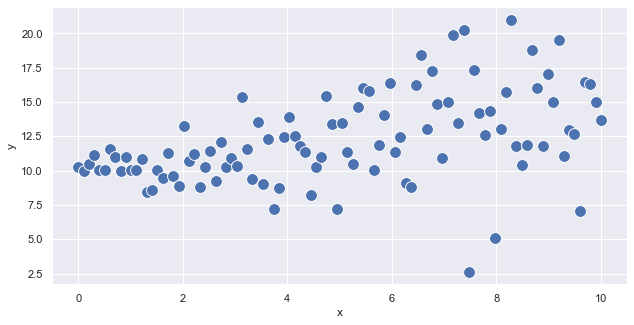

In [104]:
sns.scatterplot(data=data2, x='x', y='y', s=140)

In [105]:
data2.corr()

,x,y
x,1.000000,0.459861
y,0.459861,1.000000


### Building simple Linear Regression model. 

In [106]:
X = data2['x']
Y = data2['y']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     26.28
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.48e-06
Time:                        22:55:43   Log-Likelihood:                -248.23
No. Observations:                 100   AIC:                             500.5
Df Residuals:                      98   BIC:                             505.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6752      0.581     16.660      0.000       8.523      10.828
x              0.5144      0.100      5.127      0.000       0.315       0.713
==============================================================================
Omnibus:                       12.551   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.650
Skew:                          -0.497   Prob(JB):                     1.99e-05
Kurtosis:                       5.051   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Cheking residuals distribution

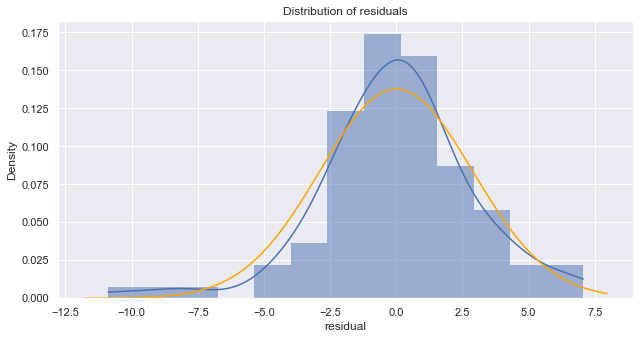

In [107]:
mu, std = stats.norm.fit(model_result.resid)
mu, std

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model_result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

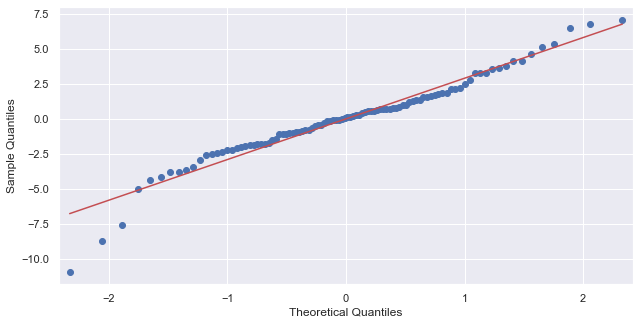

In [108]:
sm.qqplot(model_result.resid, line='s');

#### Cheking Homoscedasticity

We want to check if the error is constant along the values of the dependent variable.

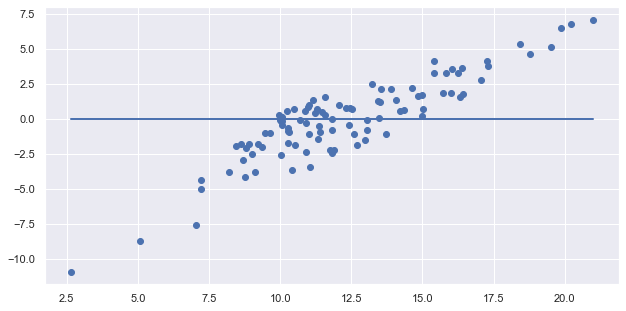

In [109]:
plt.scatter(Y, model_result.resid)
plt.plot(Y, [0]*len(Y))

<span style="color:black;font-weight:680;font-size:20px"> 
Summary:
</span>

<ul>
    <li>The negative skewness (-0.497), tells us that the tail of the distribution curve is longer on the left side. So, the residuals are not normally distributed in our model.
Also we can see it in above histogram, that shows that the Normal curve(orange) is not fitting the distribution of residuals(blue curve).
The same thing we can observe in QQ-plot.        
   </li>
    <li>Low R-square indicates that variation of dependent variable (y), is weakly explained by the independent variable X, in this model.</li>
    <li> So, we can conclude that first and second assumptions of Linear regression does not happen is this specific case. The linear relationship between predictor and label is not much strong, and distribution of residuals is not normal.</li>
    <li>The third assumption regards lack of multicollinearity is not relevant in this specific case because we have only one independent variable (x).</li>
    <li>Looks like there is no heteroskedasticity in out data. The variance of error seems constant between observations.</li>
    <li>Despite the fact that the last assumption is taking plase in our data, we probably would not like to use Linear regression for this dataset becase the first two assumptions are not met.
</ul>












We will use Quantile Regression instead.

### Building Quantile Regression. 

In [111]:
train_df, test_df = train_test_split(data2, test_size=0.10, shuffle=True)

X_train, y_train = train_df[['x']], train_df[['y']]
X_test, y_test = test_df[['x']], test_df[['y']]

In [112]:
classifiers = {}
for tau in [0.05, 0.5, 0.95]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [113]:
data = pd.DataFrame({'X': X_test.reset_index()['x'],
              '0.05': classifiers['0.05']['predictions']['0.05'],
              '0.5' : classifiers['0.5']['predictions']['0.5'],
              '0.95': classifiers['0.95']['predictions']['0.95'],
              'y': y_test.reset_index()['y']})

In [114]:
data

,X,0.05,0.5,0.95,y
0,7.171717,8.762596,14.449863,18.390265,19.870058
1,1.111111,8.825636,10.259097,13.866837,10.063952
2,4.646465,7.286257,11.381645,15.288140,11.022742
3,9.393939,6.733231,14.653670,21.000901,12.994119
4,4.848485,7.282494,12.131164,15.441535,13.429066
5,0.808081,8.825636,10.259097,13.866837,9.979617
6,3.333333,8.855812,11.585661,14.921430,9.374960
7,2.121212,8.825636,10.259097,13.866837,10.708258
8,2.525253,8.825636,10.259097,13.866837,11.458141
9,1.414141,8.825636,10.259097,13.866837,8.624973


In [115]:
melted_data = pd.melt(data, id_vars=['X'])

In [106]:
# melted_data

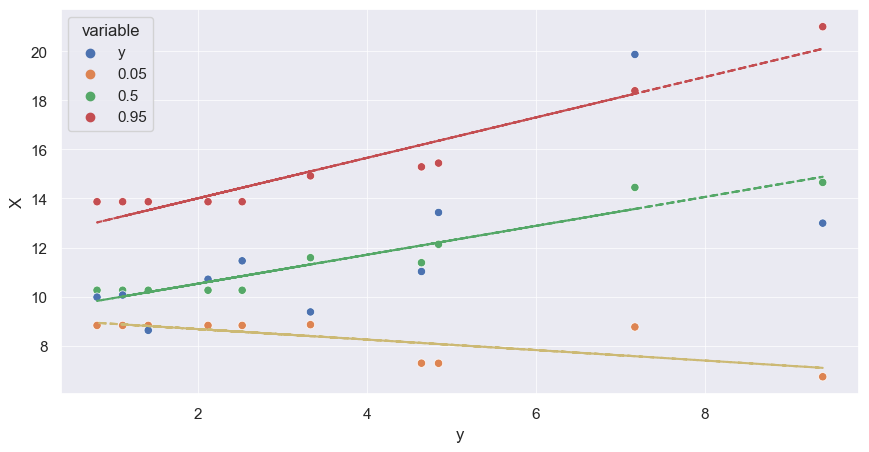

In [116]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="X",
                y='value',
                hue='variable',
                hue_order=['y', '0.05', '0.5', '0.95'],
                marker='o')

m, b = np.polyfit(data['X'], data['0.95'], 1)
plt.plot(data['X'], m*data['X']+b, 'r--')

m, b = np.polyfit(data['X'], data['0.5'], 1)
plt.plot(data['X'], m*data['X']+b, 'g--')

m, b = np.polyfit(data['X'], data['0.05'], 1)
plt.plot(data['X'], m*data['X']+b, 'y--')


plt.grid(linestyle='-', linewidth=0.5)
ylabel = plt.ylabel("X")
xlabel = plt.xlabel("y")

### Explanation of quantile regression results

# Question 3

In [175]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [155]:
data3 = pd.read_parquet('data3.parquet', engine='pyarrow')

In [156]:
data3.shape

(506, 14)

In [157]:
data3.head(10)

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


#### Checking features distribution 

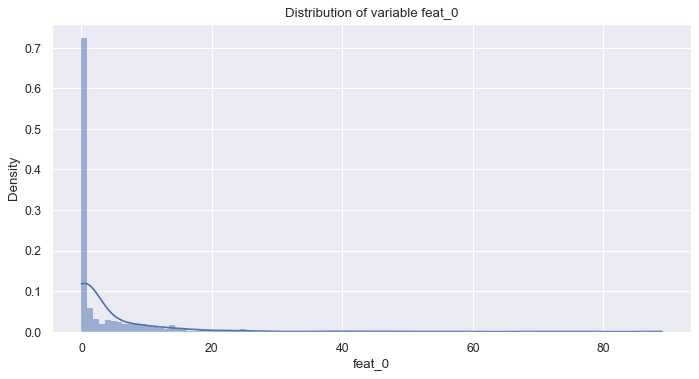

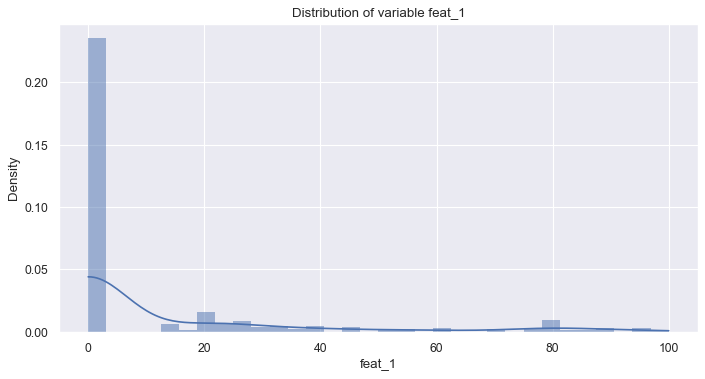

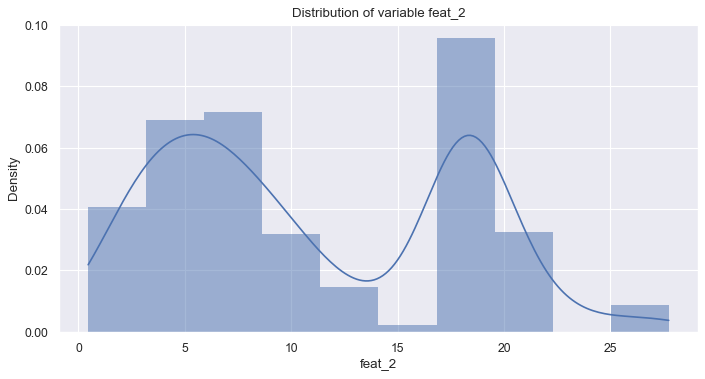

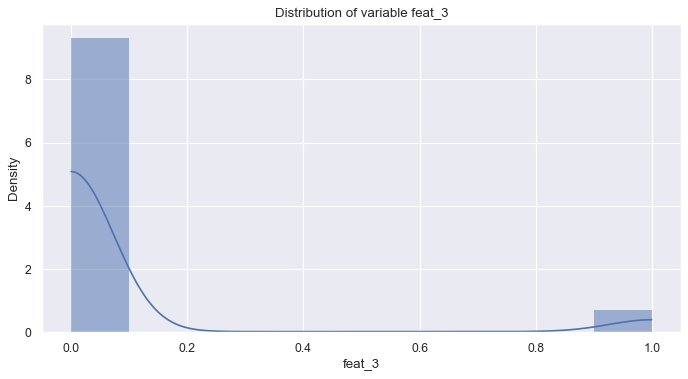

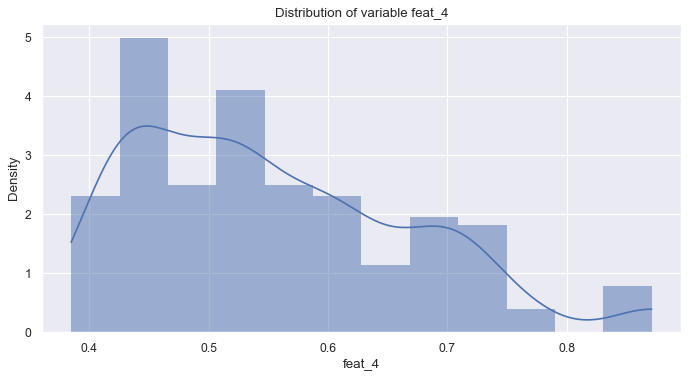

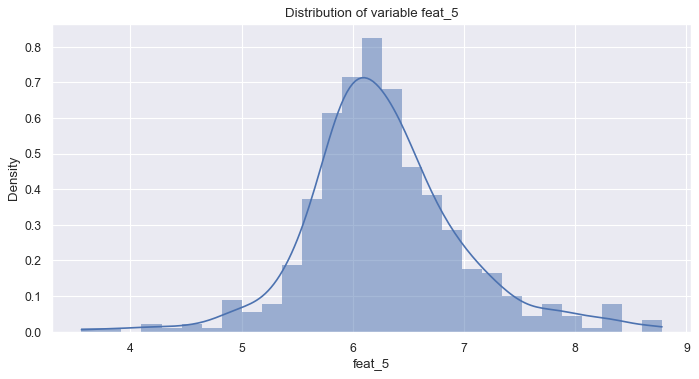

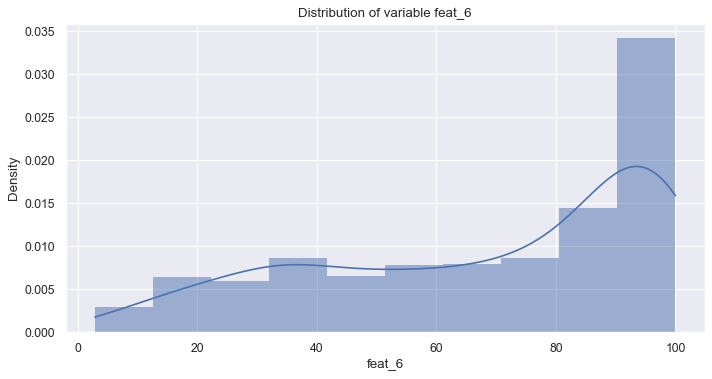

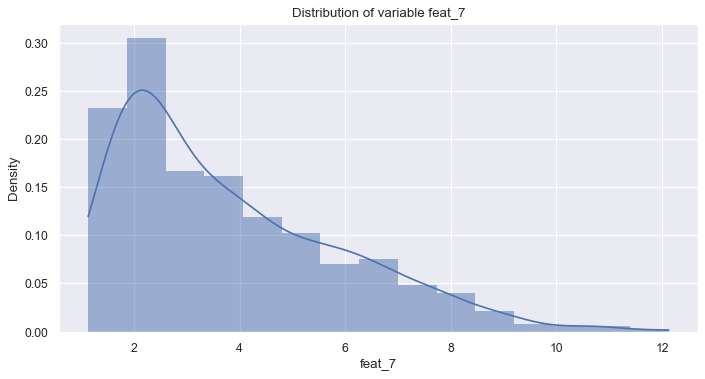

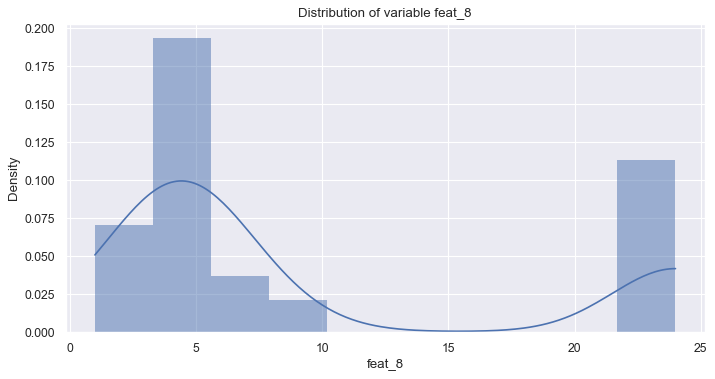

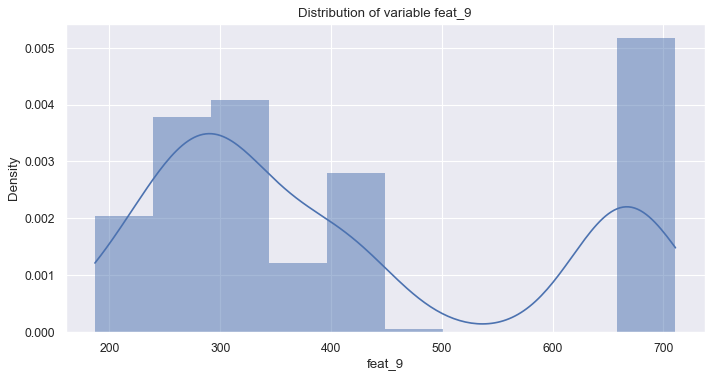

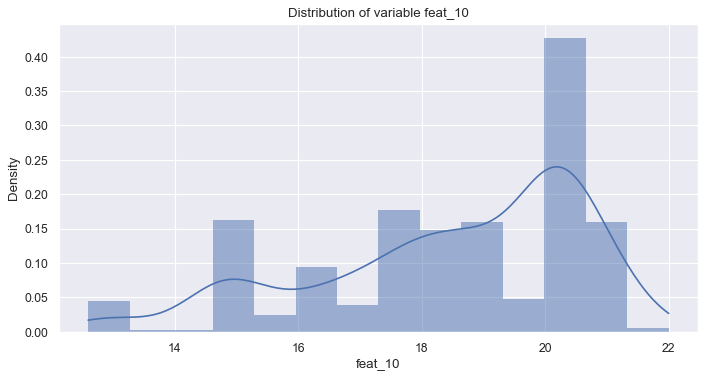

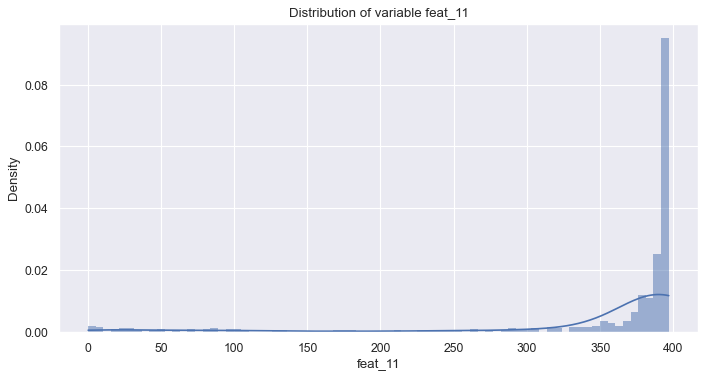

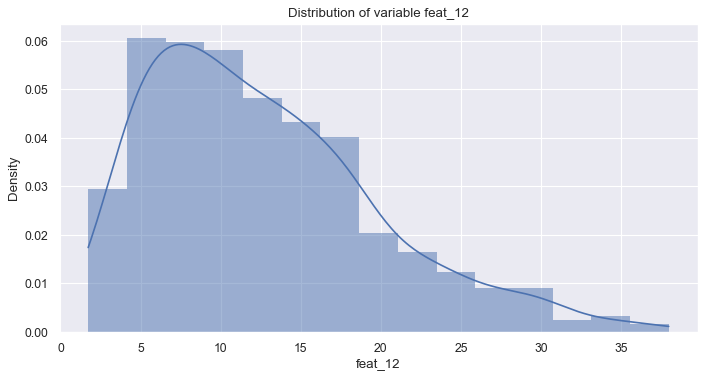

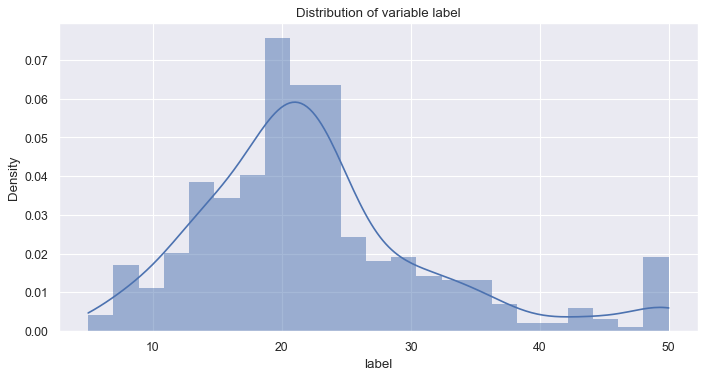

In [159]:
def plot_variable(var_list):
    plt.rcParams.update({'font.size': 8, 'figure.dpi':80})
    for i in range(len(var_list)):      
        fig, ax = plt.subplots()
        sns.histplot(x=data3[var_list[i]], ax=ax, stat="density", linewidth=0, kde=True)
        ax.set(title="Distribution of variable {}".format(var_list[i]), xlabel=var_list[i])

        # plot corresponding normal curve
        xmin, xmax = plt.xlim() # the maximum x values from the histogram above
        plt.show()
    
    
plot_variable(list(data3.columns))   

In [169]:
np.seterr(divide = 'ignore') 
data3_transformed=np.log(data3)
np.seterr(divide = 'warn') 

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [170]:
data3

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [171]:
data3_transformed

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,-5.064036,2.890372,0.837248,-inf,-0.619897,1.883275,4.177459,1.408545,0.000000,5.690359,2.727853,5.983684,1.605430,3.178054
1,-3.600502,-inf,1.955860,-inf,-0.757153,1.859574,4.368181,1.602836,0.693147,5.488938,2.879198,5.983684,2.212660,3.072693
2,-3.601235,-inf,1.955860,-inf,-0.757153,1.971996,4.112512,1.602836,0.693147,5.488938,2.879198,5.973377,1.393766,3.546740
3,-3.430523,-inf,0.779325,-inf,-0.780886,1.945624,3.824284,1.802073,1.098612,5.402677,2.928524,5.977949,1.078410,3.508556
4,-2.672924,-inf,0.779325,-inf,-0.780886,1.966693,3.992681,1.802073,1.098612,5.402677,2.928524,5.983684,1.673351,3.589059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-2.770511,-inf,2.479056,-inf,-0.556870,1.886008,4.235555,0.907694,0.000000,5.609472,3.044522,5.971236,2.269028,3.109061
502,-3.095111,-inf,2.479056,-inf,-0.556870,1.811562,4.339902,0.827460,0.000000,5.609472,3.044522,5.983684,2.206074,3.025291
503,-2.800824,-inf,2.479056,-inf,-0.556870,1.942476,4.510860,0.773574,0.000000,5.609472,3.044522,5.983684,1.729884,3.173878
504,-2.211009,-inf,2.479056,-inf,-0.556870,1.916040,4.492001,0.870833,0.000000,5.609472,3.044522,5.974954,1.868721,3.091042


In [172]:
data3_transformed = data3_transformed.replace([np.inf, -np.inf], 0.0)

#### Data preparation

In [167]:
data3_transformed.columns = data3_transformed.columns.str.replace('_', '') # Replace _ symbol from column names
data3_transformed.columns

target = "label"
features = [f for f in data3_transformed.columns if f not in ["label" "feat1" "feat3"]]  # Separate features and label

X = data3_transformed[features]
y = data3_transformed[target]


pipeline = Pipeline([ ('scaler', StandardScaler()),  # Create pipline
                      ('model',  Ridge(alpha=1)) ])


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=123) # Define cross-validation method

In [193]:
# ridge_alpha = list(np.arange(0, 1.01, 0.01))
param_grid = {'ridge__alpha': np.arange(0, 1.01, 0.01)}

In [196]:
scores_buf = []   
cnt = 0
for train_index, test_index in cv.split(X):
    #print('Fold {}'.format(cnt + 1))

    train_x,train_y = X.loc[train_index], y.loc[train_index]
    test_x, test_y = X.loc[test_index], y.loc[test_index]
       
    # create model
    model = pipeline.fit(train_x, train_y)  
    
    # evaluate model
    scores = cross_val_score(model, test_x, test_y, cv=cv, n_jobs=-1)
    
    scores_buf.append(scores)
    #print('{} Score: {}'.format(cnt, scores))

    cnt += 1

scores_mean = np.mean(scores_buf)
scores_std = np.std(scores_buf)
print('Mean and std of coefficient of determination = {:.6f} and {:.6f} respectively.'.format(scores_mean, scores_std))

Mean and std of coefficient of determination = 0.989295 and 0.034629 respectively.
